<a href="https://colab.research.google.com/github/AI-Tiger/ml-project/blob/main/GAN_ch4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/karaage0703/janken_dataset datasets
!rm -rf /content/datasets/.git
!rm /content/datasets/LICENSE

Cloning into 'datasets'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 4.60 MiB | 11.95 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten
from keras.optimizers import Adam
import numpy as np
from PIL import Image
import glob
import random
import time
import csv
import os

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

Using TensorFlow backend.


In [ ]:
def image_batch(batch_size):
    files = glob.glob('./datasets/*/*')
    files = random.sample(files, batch_size)
    res = []
    for path in files:
        img = Image.open(path)
        img = img.resize((64, 64))
        arr = np.array(img)
        arr = (arr - 127.5) / 127.5
        arr.resize((64, 64, 3))
        res.append(arr)
    return np.array(res)

In [ ]:
test_image = image_batch(25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


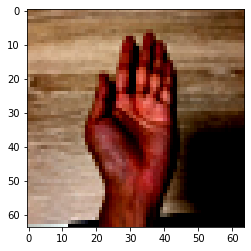

In [ ]:
plt.imshow(test_image[0])

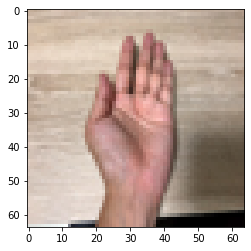

In [ ]:
plt.imshow((test_image[0]+1)/2)

In [ ]:
def combine_images(generated_images, cols=5, rows=5):
    shape = generated_images.shape
    h = shape[1]
    w = shape[2]
    image = np.zeros((rows * h, cols * w, 3))
    for index, img in enumerate(generated_images):
        if index >= cols * rows:
            break
        i = index // cols
        j = index % cols
        image[i * h:(i + 1) * h, j * w:(j + 1) * w, :] = img[:, :, :]
    image = image * 127.5 + 127.5
    image = Image.fromarray(image.astype(np.uint8))
    return image

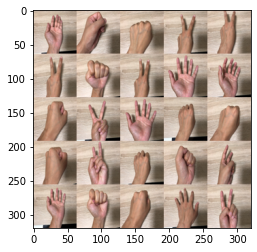

In [ ]:
test_combined_image = combine_images(test_image)
plt.imshow(test_combined_image)

In [ ]:
batch_size = 32
epochs = 1001

In [ ]:
model_dir = './model'
gen_images_dir = './gen_images'
each_step = 50

In [ ]:
def generator_model():
    model = Sequential()

    model.add(Dense(1024, input_shape=(100,)))
    model.add(Activation('tanh'))

    model.add(Dense(128 * 16 * 16))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))

    model.add(Reshape((16, 16, 128)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))

    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(3, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model

In [ ]:
def discriminator_model():
    model = Sequential()

    model.add(Conv2D(64, (5, 5), input_shape=(64, 64, 3), padding='same'))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())

    model.add(Dense(1024))
    model.add(Activation('tanh'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [ ]:
def generator_containing_discriminator(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [ ]:
def set_trainable(model, trainable):
  model.trainable = trainable
  for layer in model.layers:
    layer.trainable = trainable

discriminator = discriminator_model()
generator = generator_model()
discriminator_on_generator = generator_containing_discriminator(
    generator, discriminator)

set_trainable(discriminator, True)
discriminator.compile(
    loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

set_trainable(discriminator, False)
discriminator_on_generator.compile(
    loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

print(generator.summary())
print(discriminator.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              103424    
_________________________________________________________________
activation_5 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32768)             33587200  
_________________________________________________________________
batch_normalization_1 (Batch (None, 32768)             131072    
_________________________________________________________________
activation_6 (Activation)    (None, 32768)             0         
_________________________________________________________________
reshape_1 

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
if not os.path.isdir(gen_images_dir):
    os.mkdir(gen_images_dir)

  0%|          | 0/1001 [00:00<?, ?it/s]

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


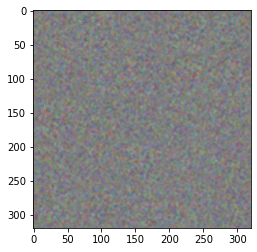

  0%|          | 1/1001 [00:19<5:17:58, 19.08s/it]/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  5%|▍         | 50/1001 [00:27<02:39,  5.95it/s]

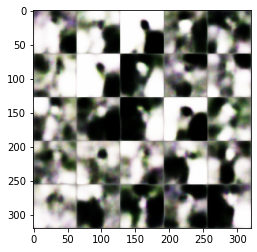

 10%|▉         | 100/1001 [00:35<02:29,  6.01it/s]

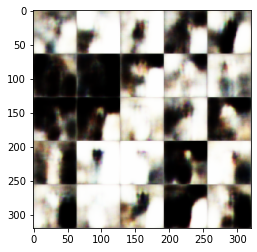

 15%|█▍        | 150/1001 [00:44<02:24,  5.88it/s]

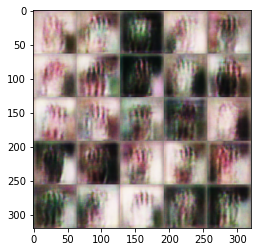

 20%|█▉        | 200/1001 [00:53<02:17,  5.83it/s]

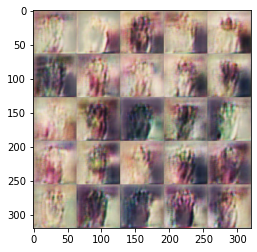

 25%|██▍       | 250/1001 [01:02<02:08,  5.86it/s]

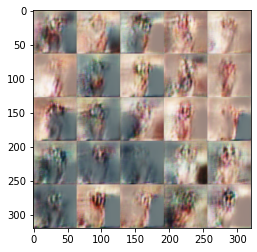

 30%|██▉       | 300/1001 [01:11<02:00,  5.82it/s]

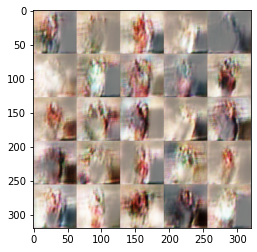

 35%|███▍      | 350/1001 [01:19<01:50,  5.88it/s]

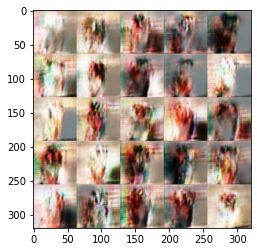

 40%|███▉      | 400/1001 [01:28<01:45,  5.68it/s]

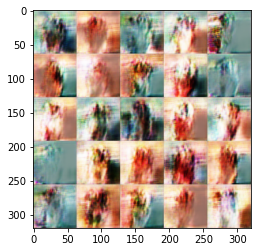

 45%|████▍     | 450/1001 [01:37<01:35,  5.76it/s]

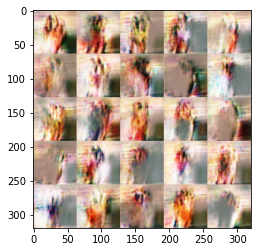

 50%|████▉     | 500/1001 [01:46<01:27,  5.72it/s]

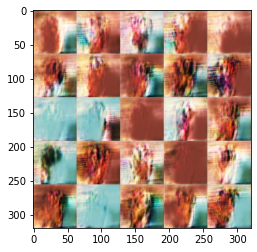

 55%|█████▍    | 550/1001 [01:56<01:20,  5.60it/s]

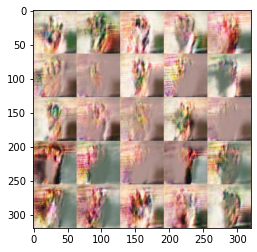

 60%|█████▉    | 600/1001 [02:05<01:12,  5.51it/s]

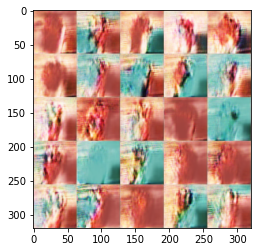

 65%|██████▍   | 650/1001 [02:14<01:02,  5.58it/s]

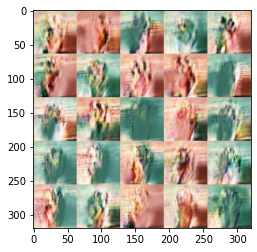

 70%|██████▉   | 700/1001 [02:23<00:53,  5.64it/s]

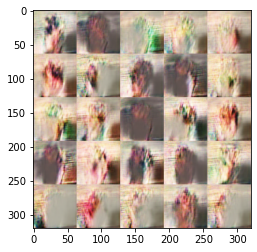

 75%|███████▍  | 750/1001 [02:32<00:45,  5.51it/s]

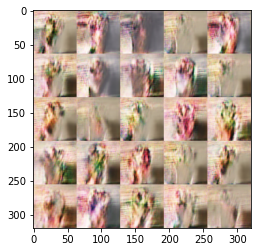

 80%|███████▉  | 800/1001 [02:42<00:36,  5.45it/s]

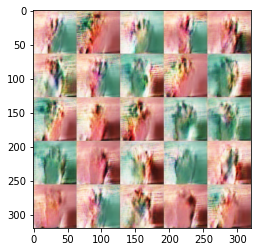

 85%|████████▍ | 850/1001 [02:51<00:27,  5.49it/s]

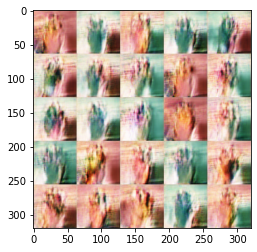

 90%|████████▉ | 900/1001 [03:00<00:18,  5.50it/s]

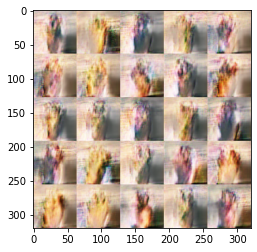

 95%|█████████▍| 950/1001 [03:10<00:09,  5.31it/s]

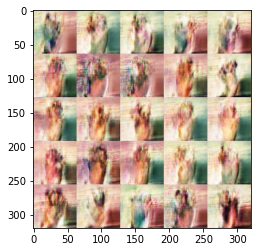

100%|█████████▉| 1000/1001 [03:19<00:00,  5.40it/s]

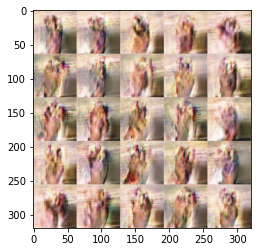

100%|██████████| 1001/1001 [03:20<00:00,  5.00it/s]


In [ ]:
# graph data
csvlist = []
csvlist.append([])
csvlist[0].append('step')
csvlist[0].append('g_loss')
csvlist[0].append('d_loss')

for i in tqdm(range(epochs)):
  batch_images = image_batch(batch_size)
  noise = np.random.uniform(
      size=[batch_size, 100], low=-1.0, high=1.0)
  generated_images = generator.predict(noise)
  X = np.concatenate((batch_images, generated_images))
  y = [1] * batch_size + [0] * batch_size
  d_loss = discriminator.train_on_batch(X, y)
  noise = np.random.uniform(
      size=[batch_size, 100], low=-1.0, high=1.0)
  g_loss = discriminator_on_generator.train_on_batch(
      noise, [1] * batch_size)

  # add graph data
  csvlist.append([])
  csvlist[i+1].append(i)
  csvlist[i+1].append(g_loss)
  csvlist[i+1].append(d_loss)

  if i % each_step == 0:
    # show result image
    image = combine_images(generated_images)
    plt.ion()
    plt.imshow(image)
    plt.pause(0.001)

    # save image
    image.save(gen_images_dir + '/gen%05d.png' % i)

# save graph data(csv)
with open('./train_graph.csv', 'w') as f:
  dataWriter = csv.writer(f)
  dataWriter.writerows(csvlist)

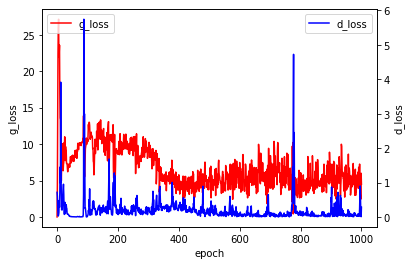

In [ ]:
data = pd.read_csv("train_graph.csv", index_col='step')

fig, ax1 = plt.subplots()
df_acc = data.iloc[:, [0]]
df_val_acc = data.iloc[:, [1]]

ax1.plot(df_acc, 'r', label='g_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('g_loss')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(df_val_acc, 'b', label='d_loss')
ax2.set_ylabel('d_loss')
ax2.legend(loc='upper right')

plt.show()

In [ ]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

save_model_path = os.path.join(model_dir, 'gan_model.h5')

generator.save(save_model_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp ./model/gan_model.h5 '/content/drive/My Drive'